# Alerts Data Introduction and EDA

The purpose of this notebook is to explore the sample data made publicly available in this repo for the OCP Alert Prediction project. This data is a snippet of the `alerts` prometheus metrics collected from CI/CD OpenShift deployments. This notebook is meant to give the user some insights on what the dataset consists of and what are some of its properties.

## Introduction

Red Hat collects alerts data from OpenShift deployments in the form of [prometheus metrics](https://prometheus.io/docs/introduction/overview/). In the prometheus time series [data model](https://prometheus.io/docs/concepts/data_model/), a data point at a given timestamp consists of a key-value pair. The key consists of the metric name and configuration labels, and the value corresponds to its value at that time. For example, consider the following two data points from a given time instance:

| Element | Value |
| --- | --- |
| alerts{\_id="1234", alertstate="firing", alertname="Watchdog", severity="none"} | 1 |
| alerts{\_id="1234", alertstate="firing", alertname="etcdMembersDown", severity="critical"} | 1 |

According to these metrics, there are two alerts firing in deployment "1234", namely, Watchdog (no severity) and etcdMembersDown (critical severity).

Since using data in this structure in data science tasks is not straightforward, we "unfolded" the metrics and stored them as a pandas dataframe so that it can be easily analyzed. So the metrics in the above example would become:

| \_id | alertstate | alertname | severity | value |
| --- | --- | --- | --- | --- |
| 1234 | firing | Watchdog | none | 1 |
| 1234 | firing | etcdMembersDown | critical | 1 |

This is essentially what the sample dataset looks like. The columns correspond to the various label configs seen in the `alerts` metric, and each row corresponds to an alert firing in a deployment. In the following section, we'll dive deeper into this data.

## EDA

In [1]:
# imports
import datetime as dt
from tqdm import tqdm
from glob import glob as gg

import numpy as np
import pandas as pd

from plotly import graph_objects as go

from IPython.display import display, Image

In [2]:
# read data from all files into one big dataframe
files = gg('../data/raw/cicd/*.parquet')
df = pd.DataFrame()
for f in tqdm(files):
    df = df.append(
        pd.read_parquet(f),
        ignore_index=True,
    )
    
print(df.shape)
df.head()

100%|██████████| 288/288 [00:20<00:00, 13.76it/s]

(42555, 53)


,__name__,_id,alertname,alertstate,prometheus,receive,severity,tenant_id,timestamp,value,...,phase,spec_provider_id,alertmanager,status,subresource,drain_time,To,quantile,api_version,persistentvolume
0,alerts,0ce2cad0-40ed-4212-86e8-0b547826b9f8,AlertmanagerReceiversNotConfigured,firing,openshift-monitoring/k8s,true,warning,FB870BF3-9F3A-44FF-9BF7-D7A047A52F43,1590364800,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,alerts,0ce2cad0-40ed-4212-86e8-0b547826b9f8,Watchdog,firing,openshift-monitoring/k8s,true,none,FB870BF3-9F3A-44FF-9BF7-D7A047A52F43,1590364800,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,alerts,26c21be7-515e-47fe-94b2-4503bf2856ed,AlertmanagerReceiversNotConfigured,firing,openshift-monitoring/k8s,true,warning,FB870BF3-9F3A-44FF-9BF7-D7A047A52F43,1590364800,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,alerts,26c21be7-515e-47fe-94b2-4503bf2856ed,Watchdog,firing,openshift-monitoring/k8s,true,none,FB870BF3-9F3A-44FF-9BF7-D7A047A52F43,1590364800,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,alerts,3daba08f-8807-47f5-b70a-bff313aad42f,AlertmanagerReceiversNotConfigured,firing,openshift-monitoring/k8s,true,warning,FB870BF3-9F3A-44FF-9BF7-D7A047A52F43,1590364800,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# when is the data from, how many timestamps, what is the granularity
ts = df['timestamp'].drop_duplicates().sort_values()
print(f'Data is collected every {(ts - ts.shift(1)).min() // 60} minutes')
print(f'Most recent data point is from timestamp {df["timestamp"].max()}')
print(f'Least recent data point is from timestamp {df["timestamp"].min()}')

Data is collected every 5.0 minutes
Most recent data point is from timestamp 1590450900
Least recent data point is from timestamp 1590364800


### On Average, How Many Alerts Are Seen Per Deployment

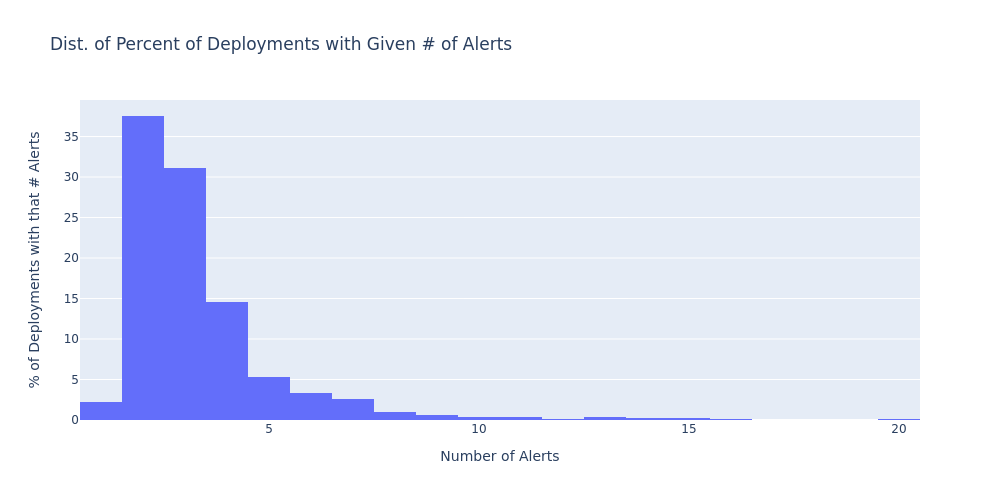

In [4]:
# for each id, calculate unique alerts observed
num_alerts_per_depl = df.groupby('_id').apply(lambda g: g['alertname'].nunique())

fig = go.Figure(
    go.Histogram(
        x=num_alerts_per_depl,
        histnorm='percent',
    ),
    layout=dict(
        title="Dist. of Percent of Deployments with Given # of Alerts",
        xaxis_title="Number of Alerts",
        yaxis_title="% of Deployments with that # Alerts",
    ),
)

# fig.show()
Image(fig.to_image(height=500, width=1000))

From the above graph, we can conclude that _most_ of the deployments have 2-4 alerts firing over the given time span. This seems reasonable, as these are CI/CD deployments and likely won't have heavy workloads running on them.

### What Alerts are the Most Popular

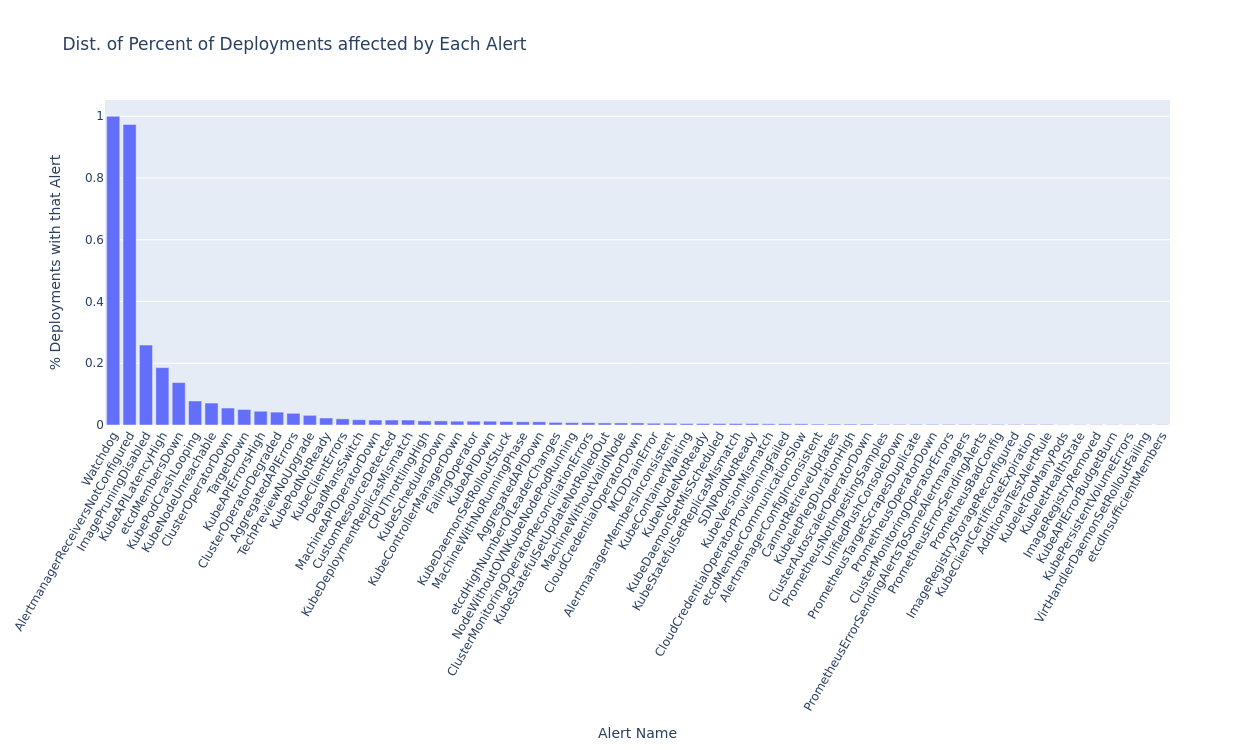

In [5]:
# in how many deployments was a given alert seen?
num_depls_affectedby_alert = df.groupby('alertname').apply(lambda g: g['_id'].nunique())

# sort in decreasing order - will help visualizing bar chart
num_depls_affectedby_alert = num_depls_affectedby_alert.sort_values(ascending=False)

fig = go.Figure(
    go.Bar(
        x=num_depls_affectedby_alert.index,
        y=num_depls_affectedby_alert.values / df['_id'].nunique(),
    ),
    layout=dict(
        title="Dist. of Percent of Deployments affected by Each Alert",
        xaxis_title="Alert Name",
        yaxis_title="% Deployments with that Alert",
        xaxis_tickangle=-60,
        margin=dict(b=250)
    ),
)
# fig.show()
Image(fig.to_image(height=750, width=1250))

From the above graph, we conclude the following
1. All deployments have the "Watchdog" alert firing. This which makes sense, since it's an alert that _always_ fires when the alert setup is functional.
2. Almost all deployments have the "AlertmanagerReceiversNotConfigured" firing. This also makes sense, since these are not production deployments.
3. After the above two, the alerts observed to fire most frequently are ImagePruningDisabled, KubeAPILatencyHigh, and etcdMembersDown. Compared to the first two, these alerts are observed in a relatively small percent of deployments (26%, 19%, and 14% respectively).
4. Other alerts not mentioned in the above points are observed in less than 7% of the deployments.

If an alert prediction model is to be trained, then it would likely be more beneficial to use one of ImagePruningDisabled, KubeAPILatencyHigh, or etcdMembersDown. This is because these are relatively abundant as compared to other meaningful alerts. Training a model on Watchdog or AlertmanagerReceiversNotConfigured would not be very useful as it would provide little help to the support engineers.

### How Many Timestamps Do We Have Alerts Data From, Per Deployment

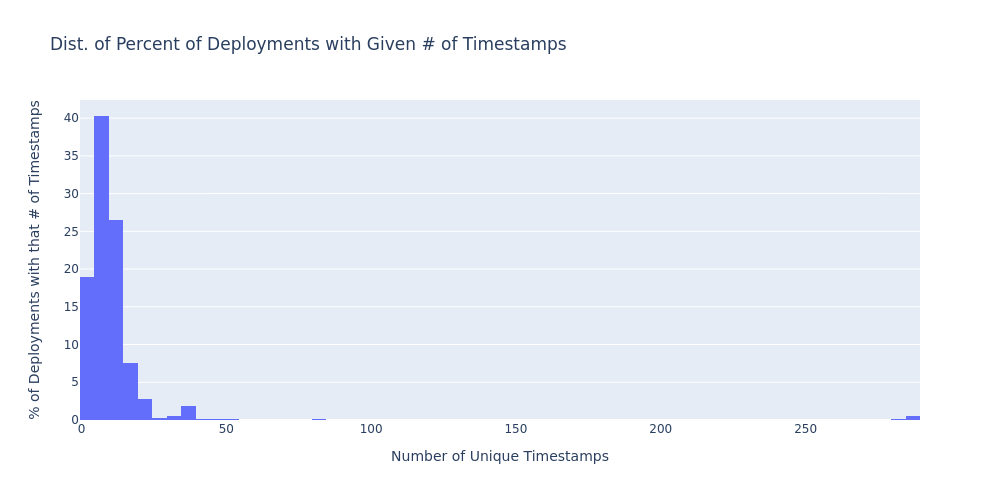

In [6]:
# for each id, calculate unique timestamps observed
num_timestamps_per_depl = df.groupby('_id').apply(lambda g: g['timestamp'].nunique())

fig = go.Figure(
    go.Histogram(
        x=num_timestamps_per_depl,
        histnorm='percent',
    ),
    layout=dict(
        title="Dist. of Percent of Deployments with Given # of Timestamps",
        xaxis_title="Number of Unique Timestamps",
        yaxis_title="% of Deployments with that # of Timestamps",
    )
)
# fig.show()
Image(fig.to_image(height=500, width=1000))

In the above graph, we can see that most deployments have alerts firing for less than 15 unique timestamps. This means that most alerts are not long-lasting. This is reasonable, since one would expect alerts to be an exception rather than a norm. For the alert prediction problem, this means that the "alert firing" class is outnumbered by the "alert not firing" class. So this is something that should be kept in mind while training the models.

### How Do the Top k Most Popular Alerts Behave Over Time

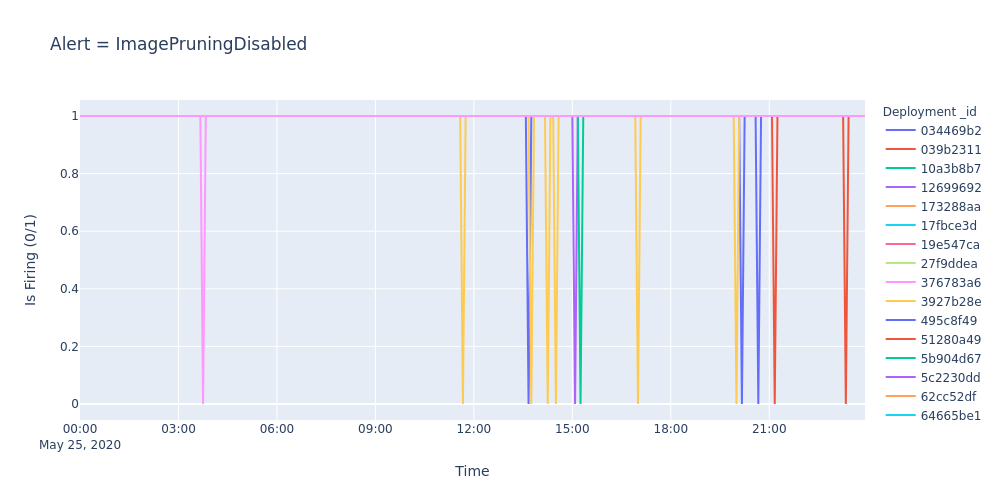

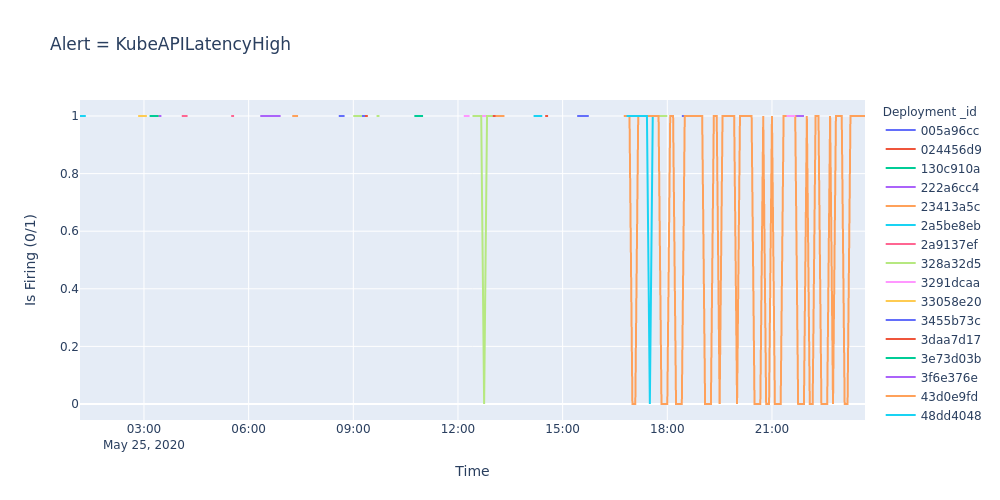

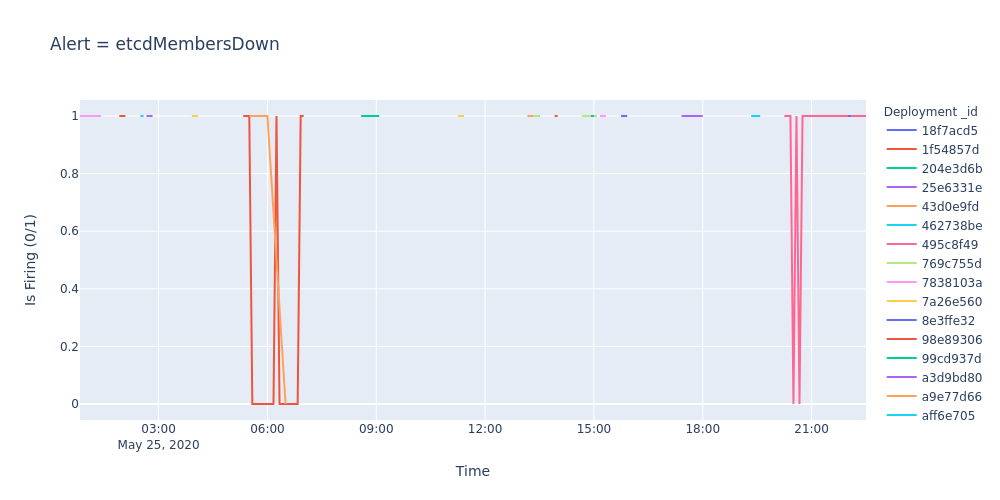

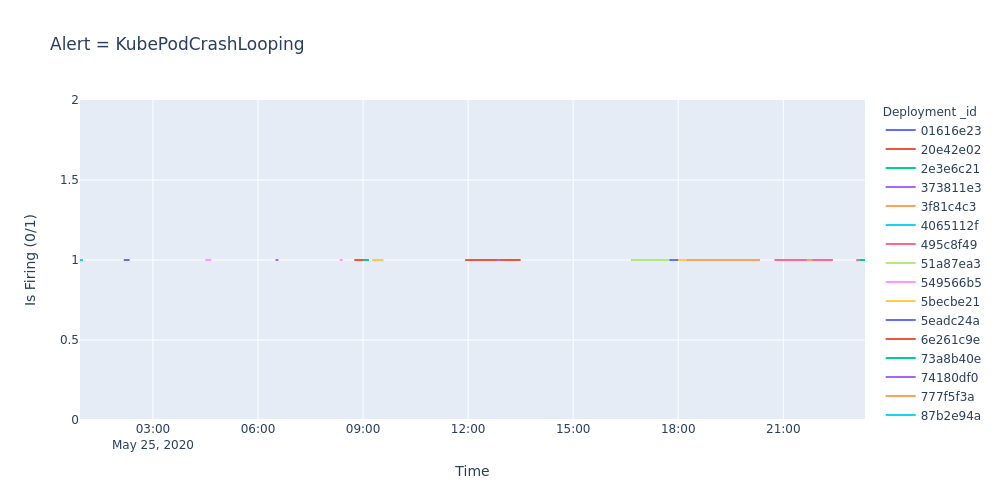

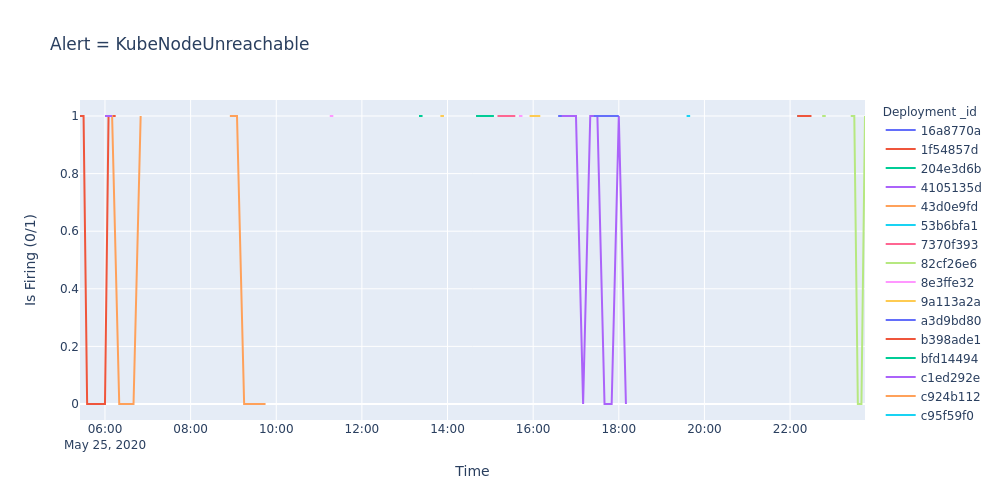

In [7]:
# NOTE: for a given alert, we cant plot data from all the deployments since
# there are around 1000 deployments in total, which wont fit in a single plot

# how many deployments, or what percent of deployments, to sample for graphing
sample_n = 50
sample_percent = 0.025

# how many alerts to create graphs for ("k" in "top k")
num_alerts_to_plot = 5

for alertname in num_depls_affectedby_alert.index[2: 2+num_alerts_to_plot]:
    # init plot for this alert
    fig = go.Figure(
        layout=dict(
            title=f'Alert = {alertname}',
            xaxis_title='Time',
            yaxis_title='Is Firing (0/1)',
            legend_title_text='Deployment _id'
        ),
    )
    
    def add_device_ts(group):
        """
        Function to add time series of a given deployment onto the plot
        """
        # ts on which data is present
        unique_ts = group['timestamp'].unique()

        if len(unique_ts) <= 1:
            return

        # form an array from first to last date for current drive
        date_range = np.arange(
            unique_ts.min(),
            unique_ts.max() + 1,
            step=unique_ts[1]-unique_ts[0],
        )

        # add this drives data to the plot
        fig.add_trace(
            go.Scatter(
                x = [dt.datetime.fromtimestamp(d) for d in date_range],
                y = np.isin(date_range, unique_ts).astype(np.uint8),
                name = group.name.split('-')[0],
                mode = 'lines',
            ),
        )
        return
    
    # sample some deployments for which we'll plot this alert's behavior over time
    sample_ids = df[df['alertname']==alertname]['_id'].sample(n=sample_n, random_state=42)
    df[(df['alertname']==alertname) & (df['_id'].isin(sample_ids))].groupby('_id').apply(add_device_ts)
    
    # fig.show()
    display(Image(fig.to_image(height=500, width=1000)))

# Conclusion

In this notebook, we explained where the alerts data in the sample dataset was collected from (prometheus metrics), and how the prometheus metrics map to the "data science friendly" format (pandas dataframe) we're storing it in. We explored some basic properties of the dataset such as how many alerts are seen, how many deployments are there, what the distribution of alerts looks like, how long do alerts fire for, etc.

This basic EDA can be useful in determining what alerts we want to use for training models, what kind of class imbalance we can expect, approximately how many useful data points exist in data collected from a day, etc. For more in-depth analysis, please check out the [single alert prediction](single_alert_time_series_pred_blog_post.ipynb), [alert correlations](alert_corr_pred.ipynb), and [multidimensional time series prediction](Multidimensional_time_series_prediction_RNN.ipynb) notebooks.